# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Capstone Project

---

#### [Capstone Project, Part 1: Proposal](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part1-proposal.ipynb)
#### [Capstone Project, Part 2: Brief](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb)
- [Writing data to MongoDB](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb#mongo_db)
- [Data Dictionary](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb#data_dictionary)
- [Map of races around the world](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part2-brief.ipynb#world-map)

#### [Capstone Project, Part 3: Technical Notebook](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb)
- [Feature Engineering](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#feature_eng)
- [Regression Approaches](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#regression_approaches)
- [Classification Approaches](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#classification_approaches)
- [Feature Importance](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#feature_importance)
- [Feature Selection](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#feature_selection)
- [Models Comparison](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part3-technical-notebook.ipynb#models_comparison)

#### [Capstone Project, Part 4: Presentation](https://61c08c5e1627a3416b0c37b4--pensive-nobel-d54f9f.netlify.app/)
#### [Capstone Project, Part 5: Appendix](https://nbviewer.org/github/jaeyow/f1-predictor/blob/main/final-project-part5-appendix.ipynb)

#### [Capstone Project, Part 6: MLOps](https://github.com/jaeyow/f1-predictor/blob/main/.github/workflows/f1-mlops.yml)
Using GitHub Actions as a cheap (and free) MLOps tool alternative: - invoke MLOps workflow on-demand (or with a cron schedule)
- get latest source
- setup Python build/MLOps environment
- data retrieval and preparation
- feature engineering
- preparation for model training (including dummify categorical features)
- feature selection
- model building and scoring
- setup serverless (lambda) API in AWS
- deploy model to serverless API
- profit!

![](./images/f1-mclaren-car.png)

## Exploratory Data Analysis
This notebook contains scripts that represent the initial Exploratoy Data analysis for this Capstone Project. The dataset we are exploring is the **Formula 1** race results from 1950 to 2021. 

### Data Collection
[Ergast Motor Racing](http://ergast.com/mrd/) has been publishing these Formula 1 results from 1950 up to the present. Majority of my data set will be from this API. For the purposes of this EDA, all data will be extracted from Ergast API. I have setup a staging area for this extracted data in a [MongoDB](https://www.mongodb.com/). I could have downloaded the data into CSV files, however, I elected to put it in on a cloud database, since my intention is to to productionize this into an API and a simple application, if time permits.  

<a id='mongo_db'></a>
#### Writing data to MongoDB
I have created 4 main tables into the MongoDB database - **races**, **drivers**, **circuits**, and **results**, which represents all the race results recorded from 1950. 

[Appendix - Writing to MongoDB](./final-project-part5-appendix.ipynb)

#### Summary of what we want to discover in this EDA
Once the data has been extracted from the source API, it is the persisted to MongoDB using the scripts above. Once in the database, we can now start our exploration, and get to know our data, find some **insights** and form our **intuition** about this dataset at this early stage. 

To summarise, these are some of the insights we want to learn from this data at this stage:

- Country/Race with the most number of races
- Weather during the race
- Map of races around the world
- Count the number of races per year
- Circuit and Year with the most number of laps
- Winningest Driver ever
- Winningest Constructor ever
- Winningest Driver Nationality
- Winningest Constructor Nationality
- Youngest Driver to win a Grand Prix
- Oldest Driver to win a Grand Prix
- Race circuit with the most number of DNF/Accidents
- Driver with the most number of DNFs
- Constructor with the most number of DNFs
- Driver age vs winning
- Grid position vs winning
- Home country racing vs winning
- Driver recent form vs winning

#### Reading data from DB to the main Data Frame to start EDA
Using the scripts below, we first get the **drivers**, **races** and **circuits** collections from MongoDB to start building the data frames required for the exploration. 

In [4]:
import requests
import json
import pandas as pd
import pymongo

conn_str = "mongodb+srv://<username>:<password>@cluster0.pagvf.mongodb.net/f1Oracle?retryWrites=true&w=majority"
connect = pymongo.MongoClient(conn_str, serverSelectionTimeoutMS=5000)

print("Connected successfully!!!")
db = connect.f1Oracle

collection = db.drivers
drivers = list(collection.find({}))

collection = db.races
races = list(collection.find({}))

collection = db.circuits
circuits = list(collection.find({}))


Connected successfully!!!


Then using race **results** collection, we merge all of these data to create the main results DataFrame (below), which we'll use as the basis of the EDA for the rest of this document. We've also cleaned up the weather column, and distilled them into 6 categorical weather types. 

In [5]:
def get_categorical_weather(weather):
    weather = weather.replace(',',' ')
    weather = weather.replace('.',' ')
    weather = weather.replace(';',' ')
    weather = weather.replace("'",' ')
    weather = weather.replace('/',' ')
    weather = weather.replace('\xa0','.')
    weather_dict = {
        'weather_hot': ['hot'],
        'weather_warm': ['soleggiato', 'clear', 'warm', 'sunny', 'fine', 'mild', 'sereno'],
        'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
        'weather_dry': ['dry', 'asciutto'],
        'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorms', 'rainy', 'drizzly'],
        'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto']}
    
    categorical_weather = ''
    for key in weather_dict:
        categorical_weather = key if any(i in weather_dict[key] for i in weather.lower().split()) else 'No weather'
        if categorical_weather != 'No weather':
            break
        else:
            categorical_weather = 'weather_warm' # a few are formatted wierd, so impute to warm 
    return categorical_weather

def create_results_dataframe_from_db_collection():
    db = connect.f1Oracle
    collection = db.results
    races_results = list(collection.find({})) # MongoDB query about ~30 seconds

    for_da_result = {'Season':[],'Round':[],'Race Name':[],'Race Date':[],'Race Time':[],'Position':[],
                     'Points':[],'Grid':[],'Laps':[],'Status':[],'Driver':[],'DOB':[],
                     'Nationality':[],'Constructor':[],'Constructor Nat':[],'Circuit Name':[],'Race Url':[],
                     'Lat':[],'Long':[],'Locality':[],'Country':[],'Weather':[]}
    
    for race in races_results:
        for results in race['Results']:
            for_da_result['Season'].append(f"{race['season']}")
            for_da_result['Round'].append(int(race['round']))
            for_da_result['Race Name'].append(f"{race['raceName']}")
            for_da_result['Race Date'].append(f"{race['date']}")
            for_da_result['Race Time'].append(f"{race['time']}" if 'time' in results else '10:10:00Z')
            for_da_result['Position'].append(int(results['position']))
            for_da_result['Points'].append(float(results['points']))
            for_da_result['Grid'].append(int(results['grid']))
            for_da_result['Laps'].append(int(results['laps']))
            for_da_result['Status'].append(f"{results['status']}")
            for_da_result['Driver'].append(f"{results['Driver']['givenName']} {results['Driver']['familyName']}")
            for_da_result['DOB'].append(f"{results['Driver']['dateOfBirth']}")
            for_da_result['Nationality'].append(f"{results['Driver']['nationality']}")
            for_da_result['Constructor'].append(f"{results['Constructor']['name']}")
            for_da_result['Constructor Nat'].append(f"{results['Constructor']['nationality']}")
            for_da_result['Circuit Name'].append(f"{race['Circuit']['circuitName']}")
            for_da_result['Race Url'].append(f"{race['url']}")
            for_da_result['Lat'].append(f"{race['Circuit']['Location']['lat']}")
            for_da_result['Long'].append(f"{race['Circuit']['Location']['long']}")
            for_da_result['Locality'].append(f"{race['Circuit']['Location']['locality']}")
            for_da_result['Country'].append(f"{race['Circuit']['Location']['country']}")
            for_da_result['Weather'].append(f"{get_categorical_weather(race['weather'])}")
                
    return pd.DataFrame(for_da_result)

results_df = create_results_dataframe_from_db_collection()
results_df

,Season,Round,Race Name,Race Date,Race Time,Position,Points,Grid,Laps,Status,...,Nationality,Constructor,Constructor Nat,Circuit Name,Race Url,Lat,Long,Locality,Country,Weather
0,1950,1,British Grand Prix,1950-05-13,10:10:00Z,1,9.0,1,70,Finished,...,Italian,Alfa Romeo,Swiss,Silverstone Circuit,http://en.wikipedia.org/wiki/1950_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_warm
1,1950,1,British Grand Prix,1950-05-13,10:10:00Z,2,6.0,2,70,Finished,...,Italian,Alfa Romeo,Swiss,Silverstone Circuit,http://en.wikipedia.org/wiki/1950_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_warm
2,1950,1,British Grand Prix,1950-05-13,10:10:00Z,3,4.0,4,70,Finished,...,British,Alfa Romeo,Swiss,Silverstone Circuit,http://en.wikipedia.org/wiki/1950_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_warm
3,1950,1,British Grand Prix,1950-05-13,10:10:00Z,4,3.0,6,68,+2 Laps,...,French,Talbot-Lago,French,Silverstone Circuit,http://en.wikipedia.org/wiki/1950_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_warm
4,1950,1,British Grand Prix,1950-05-13,10:10:00Z,5,2.0,9,68,+2 Laps,...,French,Talbot-Lago,French,Silverstone Circuit,http://en.wikipedia.org/wiki/1950_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_warm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25375,2021,21,Saudi Arabian Grand Prix,2021-12-05,10:10:00Z,16,0.0,17,44,Collision damage,...,German,Aston Martin,British,Jeddah Street Circuit,http://en.wikipedia.org/wiki/2021_Saudi_Arabia...,21.5433,39.1728,Jeddah,Saudi Arabia,weather_warm
25376,2021,21,Saudi Arabian Grand Prix,2021-12-05,10:10:00Z,17,0.0,5,14,Collision,...,Mexican,Red Bull,Austrian,Jeddah Street Circuit,http://en.wikipedia.org/wiki/2021_Saudi_Arabia...,21.5433,39.1728,Jeddah,Saudi Arabia,weather_warm
25377,2021,21,Saudi Arabian Grand Prix,2021-12-05,10:10:00Z,18,0.0,20,14,Collision,...,Russian,Haas F1 Team,American,Jeddah Street Circuit,http://en.wikipedia.org/wiki/2021_Saudi_Arabia...,21.5433,39.1728,Jeddah,Saudi Arabia,weather_warm
25378,2021,21,Saudi Arabian Grand Prix,2021-12-05,10:10:00Z,19,0.0,14,14,Collision,...,British,Williams,British,Jeddah Street Circuit,http://en.wikipedia.org/wiki/2021_Saudi_Arabia...,21.5433,39.1728,Jeddah,Saudi Arabia,weather_warm


In [6]:
# Check the column values for weather after weather adjustment
results_df.Weather.unique()

array(['weather_warm', 'weather_wet', 'weather_hot', 'weather_dry',
       'weather_cold', 'weather_cloudy'], dtype=object)

<a id='data_dictionary'></a>
#### F1 Race Results Data Dictionary

- **Season** - An F1 year
- **Round** - Each Grand Prix is also called a Round
- **Race Name** - The offical name of the race
- **Race Date** - The date when the race was held
- **Race Time** - The time of the day when the race was held
- **Position** - The finishing position at the end of the race
- **Points** - Top 10 finishers get points based in finishing position
- **Grid** - The grid position of the driver at the start of the race
- **Laps** - Number of laps of the race
- **Status** - Finishing status of the driver
- **Driver** - Driver details
- **DOB** - Driver's date of birth
- **Nationality** - Driver's nationality
- **Constructor** - Constructor details
- **Constructor Nat** - Nationality of the Constructor
- **Circuit Name** - Name of the Racing circuit venue
- **Race Url** - The Url of the Race
- **Lat** - Race circuit Latitude
- **Long** - Race circiut Longitude
- **Locality** - Location/Region of the race venue
- **Country** - The Coutry of the race
- **Weather** - The Weather conditions during the race


What does our dataset look like? Let's find out by checking out its shape:

In [8]:
results_df.shape

(25380, 22)

Display a sample slice to get an initial feel of how the results look:

In [9]:
results_df.sample(5)

,Season,Round,Race Name,Race Date,Race Time,Position,Points,Grid,Laps,Status,...,Nationality,Constructor,Constructor Nat,Circuit Name,Race Url,Lat,Long,Locality,Country,Weather
22081,2013,17,Abu Dhabi Grand Prix,2013-11-03,10:10:00Z,15,0.0,15,54,+1 Lap,...,Finnish,Williams,British,Yas Marina Circuit,http://en.wikipedia.org/wiki/2013_Abu_Dhabi_Gr...,24.4672,54.6031,Abu Dhabi,UAE,weather_warm
1719,1958,7,British Grand Prix,1958-07-19,10:10:00Z,16,0.0,8,19,Suspension,...,French,BRM,British,Silverstone Circuit,http://en.wikipedia.org/wiki/1958_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_warm
19352,2007,6,Canadian Grand Prix,2007-06-10,10:10:00Z,2,8.0,3,70,Finished,...,German,BMW Sauber,German,Circuit Gilles Villeneuve,http://en.wikipedia.org/wiki/2007_Canadian_Gra...,45.5,-73.5228,Montreal,Canada,weather_warm
11305,1987,16,Australian Grand Prix,1987-11-15,10:10:00Z,18,0.0,17,45,Electrical,...,French,Larrousse,French,Adelaide Street Circuit,http://en.wikipedia.org/wiki/1987_Australian_G...,-34.9272,138.617,Adelaide,Australia,weather_warm
932,1954,5,British Grand Prix,1954-07-17,10:10:00Z,21,0.0,27,40,Engine,...,Italian,Maserati,Italian,Silverstone Circuit,http://en.wikipedia.org/wiki/1954_British_Gran...,52.0786,-1.01694,Silverstone,UK,weather_cold


Now let's see if there are any nulls that we need to something about. No nulls, so this means that we can continue.

In [10]:
results_df.isnull().sum()

Season             0
Round              0
Race Name          0
Race Date          0
Race Time          0
Position           0
Points             0
Grid               0
Laps               0
Status             0
Driver             0
DOB                0
Nationality        0
Constructor        0
Constructor Nat    0
Circuit Name       0
Race Url           0
Lat                0
Long               0
Locality           0
Country            0
Weather            0
dtype: int64

#### Country/Race with the most number of races

Formula 1 is a global extravaganza held in many international venues and many more who would like to be part of the excitement and commercial opportunities that the race offers. Many Race circuits have been participating over the years, and there are several that have been doing these for decades. 

British Grand Prix          72
Italian Grand Prix          72
Monaco Grand Prix           67
Belgian Grand Prix          66
German Grand Prix           64
French Grand Prix           61
Spanish Grand Prix          51
Canadian Grand Prix         50
Brazilian Grand Prix        47
United States Grand Prix    42
Hungarian Grand Prix        36
Japanese Grand Prix         35
Australian Grand Prix       35
Austrian Grand Prix         34
Dutch Grand Prix            31
San Marino Grand Prix       26
European Grand Prix         23
South African Grand Prix    23
Mexican Grand Prix          20
Argentine Grand Prix        20
Name: Race Name, dtype: int64


<AxesSubplot:title={'center':'Formula 1 Race Circuits, 1950 to 2021'}>

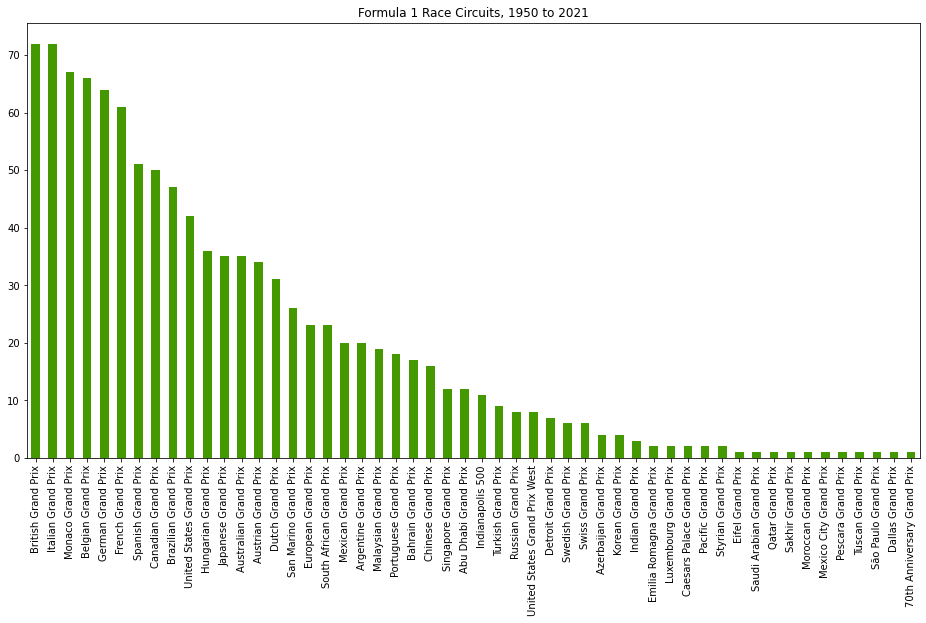

In [11]:
df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='last')
print(df_circuits['Race Name'].value_counts().head(20))
df_circuits['Race Name'].value_counts().plot(kind='bar', title="Formula 1 Race Circuits, 1950 to 2021", figsize=(16, 8), color='#449900')

#### Weather during the Race
The weather condition during the race is a major contributing factor to the results of the race. There are just drivers that perform better in extreme conditions. We strongly suggest that the weather is a major cotributor to the outcome of the race. 

In [12]:
weather = results_df.drop_duplicates(subset=['Season', 'Round'], keep='first').Weather.value_counts().head(20)
weather

weather_warm      578
weather_dry       192
weather_hot       105
weather_wet        88
weather_cloudy     63
weather_cold       30
Name: Weather, dtype: int64

<a id='world-map'></a>
#### Map of races around the world
We have use the [folium library](http://python-visualization.github.io/folium/) to create this world map visualisation of past races. The map is interactive, so please click on the bubbles and explore them deeper. Please use this link if the map does not display properly.

Italy           102
Germany          79
UK               76
USA              71
Monaco           67
Belgium          66
France           62
Spain            58
Canada           50
Brazil           48
Japan            37
Hungary          36
Austria          36
Australia        35
Netherlands      31
South Africa     23
Mexico           21
Argentina        20
Malaysia         19
Bahrain          18
Name: Country, dtype: int64


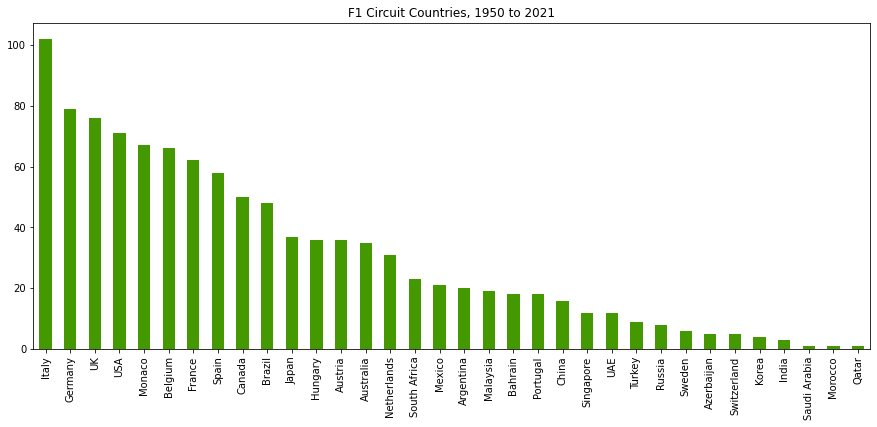

In [13]:
import folium

def map_the_countries(df):
    # Create a world map to show distributions of race venues 
    from folium.plugins import MarkerCluster
    #empty map
    world_map = folium.Map(tiles="cartodbpositron")
    marker_cluster = MarkerCluster().add_to(world_map)
    #for each coordinate, create circlemarker of user percent
    for i in range(len(df)):
            lat = df.iloc[i]['Lat']
            long = df.iloc[i]['Long']
            radius=5
            popup_text = f"Year {df.iloc[i]['Season']}"
            folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
    #show the map
    return world_map
    
# Map of races around the world
df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='last')
df_circuits = df_circuits[['Season','Round','Race Name','Lat','Long','Country']]
print(df_circuits.Country.value_counts().head(20))
df_circuits.Country.value_counts().plot(kind='bar', title="F1 Circuit Countries, 1950 to 2021", figsize=(15, 6), color='#449900')
map_races = map_the_countries(df_circuits)
map_races

#### Count the number of races per year

Formula 1 is participated in by 10 teams (called Constructors) where some Contructors are better funded thatn others. Those with deeper pockets tend to be well managed and may tend to have better race results the more races in the season. 

   Season  Number of Races
0    1950                7
1    1951                8
2    1952                8
3    1953                9
4    1954                9
5    1955                7
6    1956                8
7    1957                8
8    1958               11
9    1959                9
10   1960               10
11   1961                8
12   1962                9
13   1963               10
14   1964               10
15   1965               10
16   1966                9
17   1967               11
18   1968               12
19   1969               11


<AxesSubplot:title={'center':'F1 Year Races, 1950 to 2021'}, xlabel='Season'>

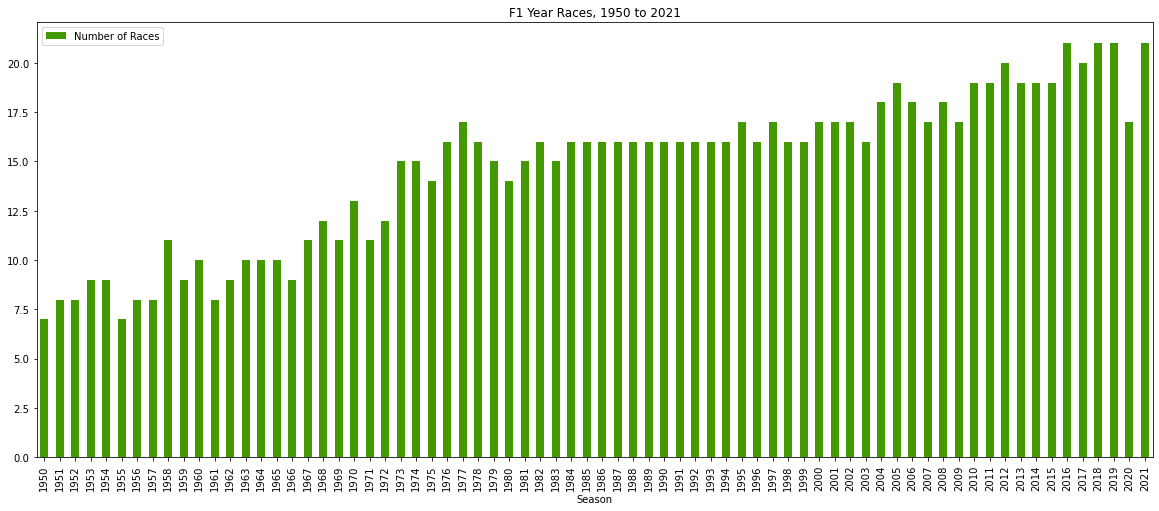

In [17]:
import numpy as np
num_races_result = {'Season':[], 'Number of Races':[]}

for season in results_df['Season'].unique():
    df_circuits = results_df[(results_df.Season == f"{season}")]
    df_grouped = df_circuits.groupby(['Season','Round'])
    race_count = df_grouped['Round'].head(1).count()
    num_races_result['Season'].append(f"{season}")
    num_races_result['Number of Races'].append(race_count)
    
df_num_races = pd.DataFrame(num_races_result)
print(df_num_races.head(20))

df_num_races.plot(kind='bar', x='Season', y='Number of Races', title="F1 Year Races, 1950 to 2021", figsize=(20, 8), color='#449900')

#### Circuit with the most number of laps

Constructors with better finding (and car build quality) may place better the longger and rougher the race conditions. 

<AxesSubplot:title={'center':'F1 Top 20 Most # of Laps, 1950 to 2021'}, ylabel='ForXLabel'>

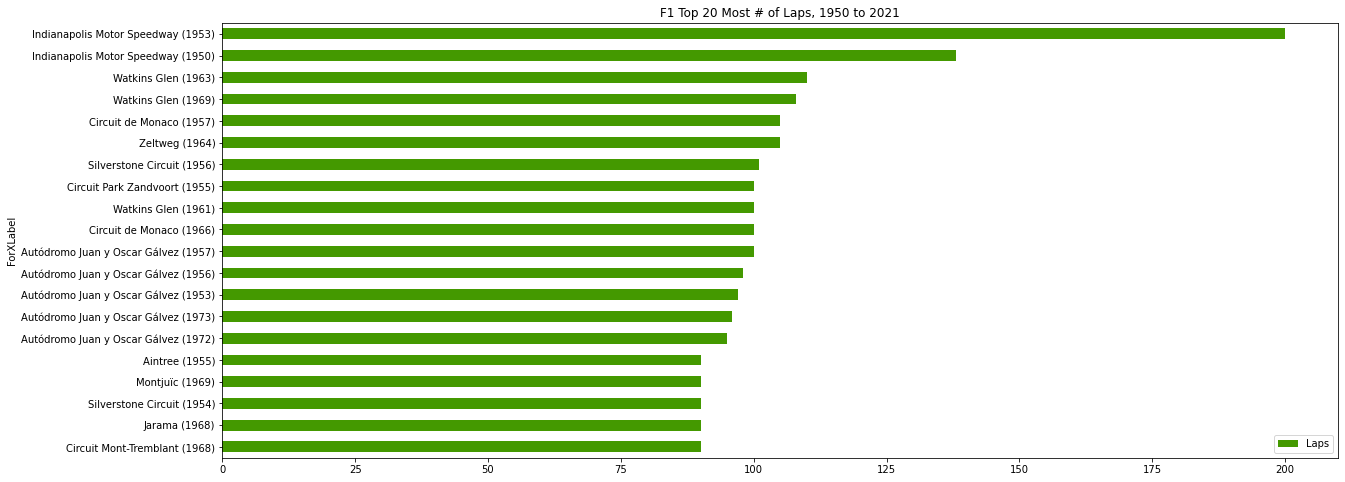

In [18]:
def combine_circuit_year(circuit, year):
    return f"{circuit} ({year})"

df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')
df_circuits = df_circuits[['Season','Round','Race Name','Circuit Name','Laps','Locality','Country']]
df_circuits.sort_values(by=['Laps'], ascending=True, inplace=True)
df_circuits = df_circuits.drop_duplicates(subset=['Laps', 'Circuit Name'], keep='first')
df = pd.DataFrame(df_circuits.tail(20))
df['ForXLabel'] = df.apply(lambda x: combine_circuit_year(x['Circuit Name'], x['Season']), axis=1)
df.plot(kind='barh', x='ForXLabel', y='Laps', title="F1 Top 20 Most # of Laps, 1950 to 2021", figsize=(20, 8), color='#449900')

#### Winningest Driver ever

Drivers (and Constructors) who have a record of winning, most probably will continue winning. 

                    Win Count
Lewis Hamilton            103
Michael Schumacher         91
Sebastian Vettel           53
Alain Prost                51
Ayrton Senna               41
Fernando Alonso            32
Nigel Mansell              31
Jackie Stewart             27
Jim Clark                  25
Niki Lauda                 25


<AxesSubplot:title={'center':'F1 Top Drivers, 1950 to 2021'}>

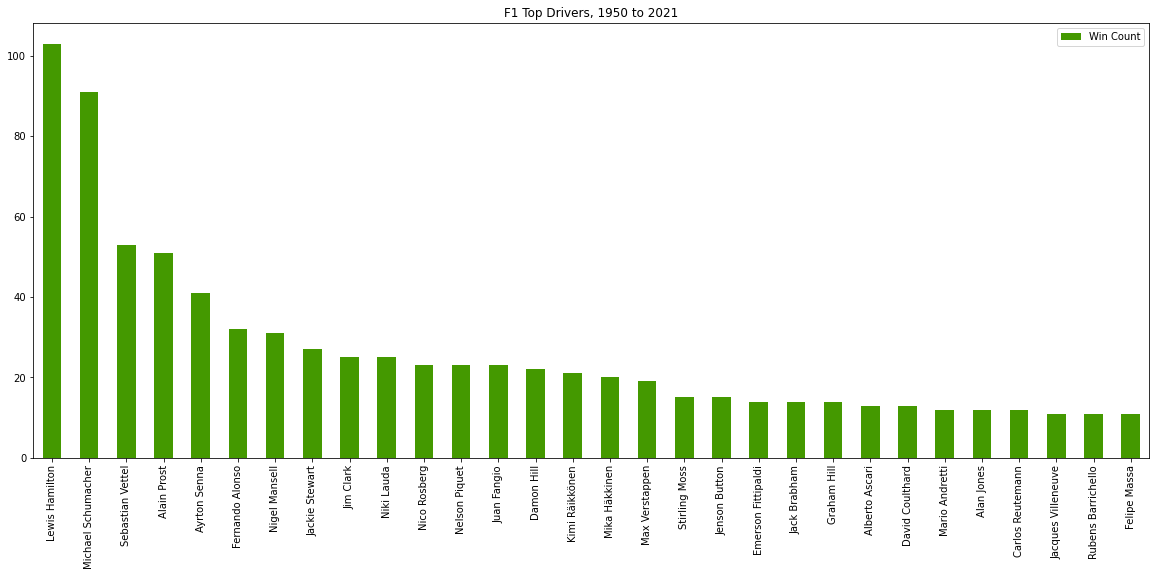

In [19]:
df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')
df_win_count = pd.DataFrame(df_circuits.Driver.value_counts())
df_win_count.rename(columns = {'Driver':'Win Count'}, inplace = True)
df_win_count.sort_values(by=['Win Count'], ascending=False, inplace=True)
print(df_win_count.head(10))
df_win_count.head(30).plot(kind='bar', title="F1 Top Drivers, 1950 to 2021", figsize=(20, 8), color='#449900')

#### Winningest Driver nationality

Is it correct to assume that some Nationalities are just better in racing than others?

            Win Count
British           307
German            179
Brazilian         101
French             81
Finnish            57
Australian         43
Italian            42
Austrian           41
Argentine          37
American           33


<AxesSubplot:title={'center':'F1 Top Driver Nationality, 1950 to 2021'}>

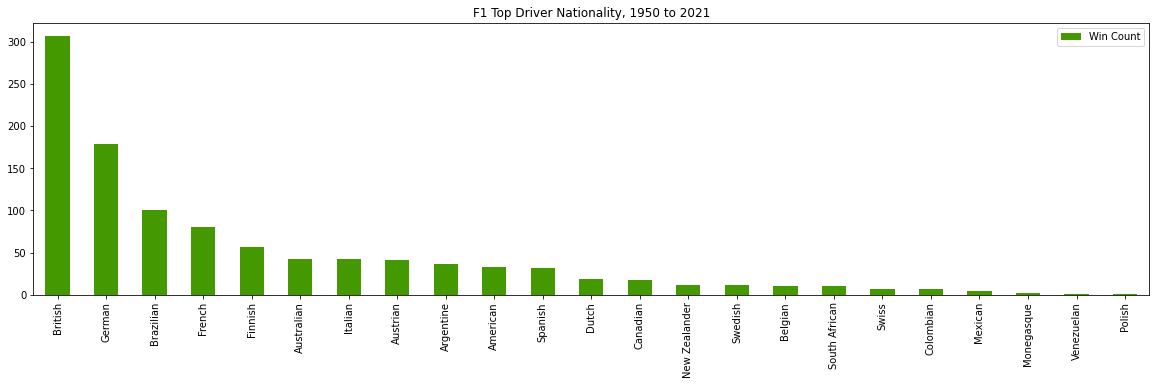

In [20]:
df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')
df_win_count = pd.DataFrame(df_circuits.Nationality.value_counts())
df_win_count.rename(columns = {'Nationality':'Win Count'}, inplace = True)
df_win_count.sort_values(by=['Win Count'], ascending=False, inplace=True)
print(df_win_count.head(10))
df_win_count.plot(kind='bar', title="F1 Top Driver Nationality, 1950 to 2021", figsize=(20, 5), color='#449900')

#### Winningest Constructor ever

            Win Count
Ferrari           238
McLaren           179
Mercedes          124
Williams          114
Red Bull           74
Team Lotus         45
Renault            35
Benetton           27
Brabham            23
Tyrrell            23


<AxesSubplot:title={'center':'F1 Top Constructors, 1950 to 2021'}>

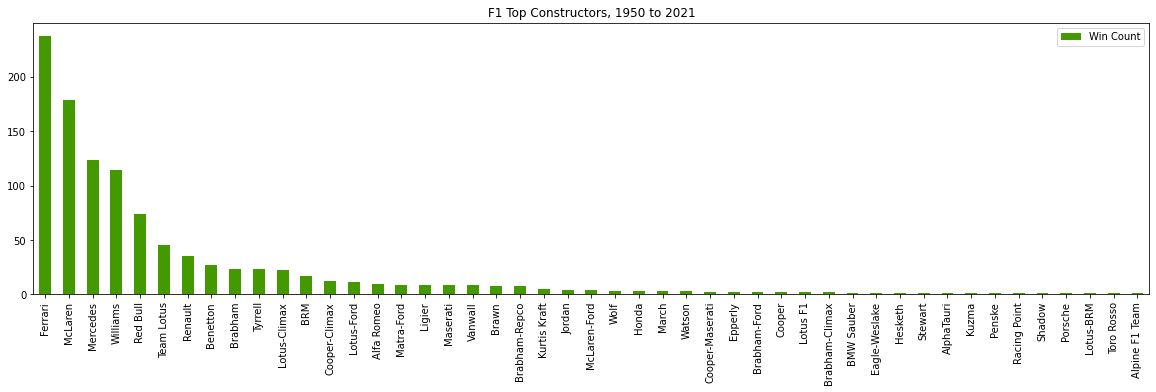

In [21]:
df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')
df_win_count = pd.DataFrame(df_circuits.Constructor.value_counts())
df_win_count.rename(columns = {'Constructor':'Win Count'}, inplace = True)
df_win_count.sort_values(by=['Win Count'], ascending=False, inplace=True)
print(df_win_count.head(10))
df_win_count.plot(kind='bar', title="F1 Top Constructors, 1950 to 2021", figsize=(20, 5), color='#449900')

#### Winningest Constructor nationality

          Win Count
British         493
Italian         276
German          126
Austrian         74
French           54
American         13
Swiss            10
Irish             4
Japanese          3
Canadian          3


<AxesSubplot:title={'center':'F1 Top Constructor Nationality, 1950 to 2021'}>

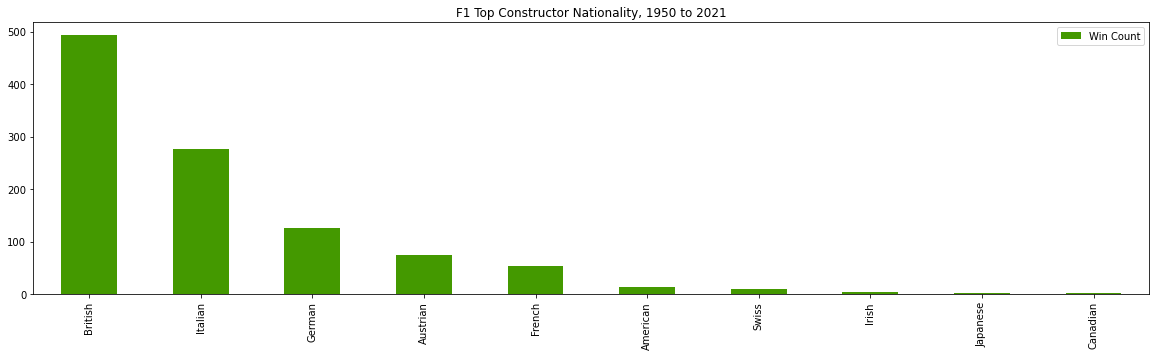

In [22]:
df_circuits = results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')
df_win_count = pd.DataFrame(df_circuits['Constructor Nat'].value_counts())
df_win_count.rename(columns = {'Constructor Nat':'Win Count'}, inplace = True)
df_win_count.sort_values(by=['Win Count'], ascending=False, inplace=True)
print(df_win_count.head(10))
df_win_count.plot(kind='bar', title="F1 Top Constructor Nationality, 1950 to 2021", figsize=(20, 5), color='#449900')

#### Youngest Driver to win a Grand Prix

There seems to be a trend that Grand Prix winners are getting younger every year. 

In [23]:
from datetime import date
from datetime import datetime

def calculate_age(born, race):
    date_born = datetime.strptime(born,'%Y-%m-%d')
    date_race = datetime.strptime(race,'%Y-%m-%d')
    return date_race.year - date_born.year - ((date_race.month, date_race.day) < (date_born.month, date_born.day))

df_circuits = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first'))
df_circuits['Age'] = df_circuits.apply(lambda x: calculate_age(x['DOB'], x['Race Date']), axis=1) 
df_circuits.sort_values(by=['Age'], ascending=True, inplace=True)
df_circuits.drop_duplicates(subset=['Driver'], keep='first',inplace=True)
df_circuits[['Driver','Age']].head(20)

,Driver,Age
23006,Max Verstappen,18
24460,Charles Leclerc,21
19883,Sebastian Vettel,21
1988,Bruce McLaren,22
18029,Fernando Alonso,22
19351,Lewis Hamilton,22
361,Troy Ruttman,22
19743,Robert Kubica,23
4369,Emerson Fittipaldi,23
3802,Jacky Ickx,23


#### Oldest Driver to win a Grand Prix

Older Drivers find it harder and harder to win races? Correct? 

In [24]:
from datetime import date
from datetime import datetime

def calculate_age(born, race):
    date_born = datetime.strptime(born,'%Y-%m-%d')
    date_race = datetime.strptime(race,'%Y-%m-%d')
    return date_race.year - date_born.year - ((date_race.month, date_race.day) < (date_born.month, date_born.day))

df_circuits = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first'))
df_circuits['Age'] = df_circuits.apply(lambda x: calculate_age(x['DOB'], x['Race Date']), axis=1) 
df_circuits.sort_values(by=['Age'], ascending=False, inplace=True)
df_circuits.drop_duplicates(subset=['Driver'], keep='first',inplace=True)
df_circuits[['Driver','Age']].head(20)

,Driver,Age
711,Nino Farina,46
1473,Juan Fangio,46
339,Piero Taruffi,45
4120,Jack Brabham,43
1440,Sam Hanks,42
14817,Nigel Mansell,41
1581,Maurice Trintignant,40
3975,Graham Hill,40
181,Lee Wallard,40
24120,Kimi Räikkönen,39


#### Race circuit with the most number of DNF/Accidents

Some Circuits are harder than others, and there is a certain breed of drivers that thrive in these conditions. 

<AxesSubplot:title={'center':'F1 Circuits with highest DNF rate, 1950 to 2021'}, xlabel='Race Name'>

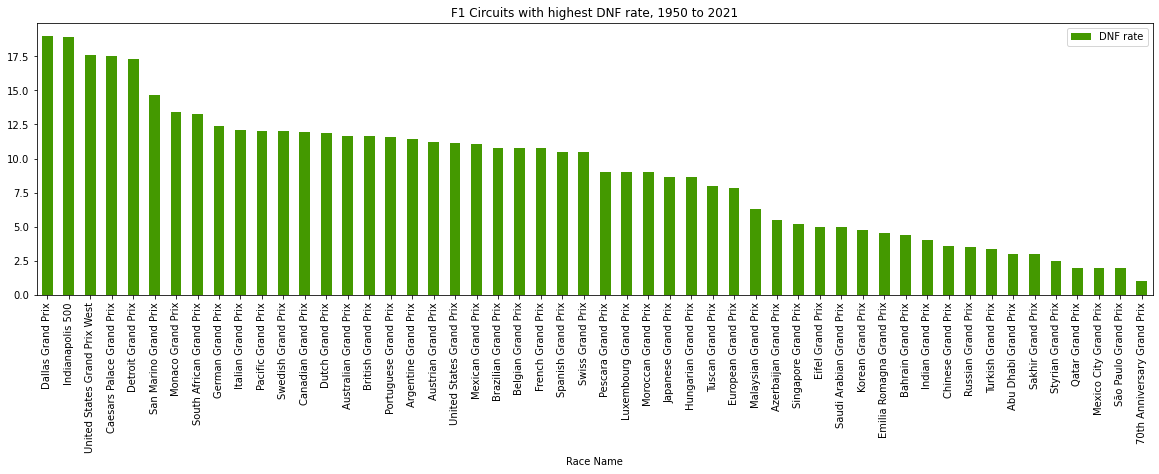

In [25]:
import numpy as np
not_finish_circuit = {'Season':[], 'Race Name':[], 'Unfinished Status':[]}

def count_races_from_beginning(df, race_name):
    df = df.drop_duplicates(subset=['Season', 'Round'], keep='first')
    races = df.groupby(by=['Race Name'])['Race Name'].count()
    return races[race_name]
    
df_status_count = results_df[(~results_df['Status'].str.contains('Finished|\+'))]

df_status = df_status_count.groupby(['Race Name'])[['Status']].count()
df_status.sort_values(by='Status', ascending=False, inplace=True)
df_status['Total Races'] = df_status.apply(lambda x: count_races_from_beginning(results_df, x.name), axis=1) 
df_status['DNF rate'] = df_status.apply(lambda x: round(x['Status']/x['Total Races'],2), axis=1)
df_status.sort_values(by=['DNF rate'], ascending=False, inplace=True)
df_status
df_status.plot(kind='bar', y='DNF rate', title="F1 Circuits with highest DNF rate, 1950 to 2021", figsize=(20, 5), color='#449900')

#### Driver with the most number of DNFs

Whatever the reason for a Driver to DNF (Did Not Finish) - Accidents, regardless of whose fault it is, this will be counted towards a DNF. 

<AxesSubplot:title={'center':'F1 Driver with highest DNF rate, 1950 to 2021'}, xlabel='Driver'>

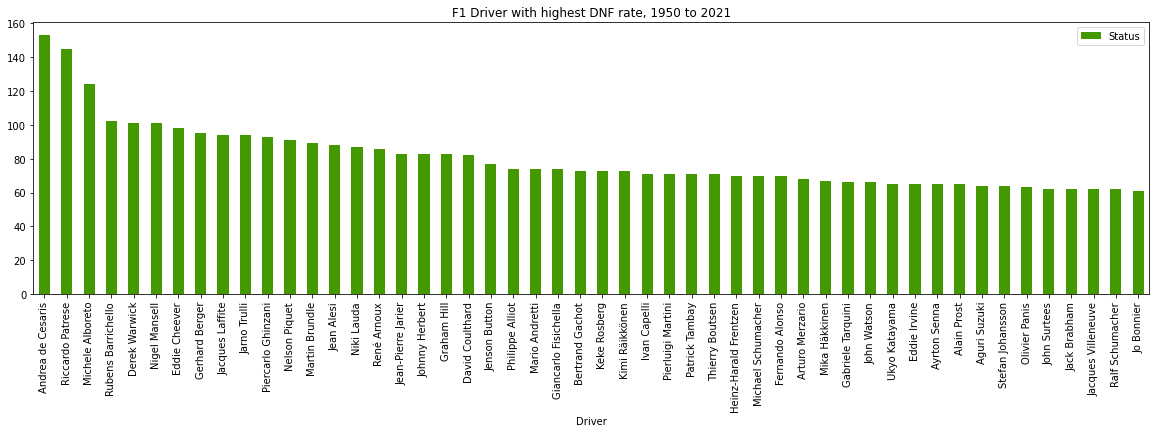

In [30]:
def get_driver_total_races(df, driver_name):
    group = df.groupby(by=['Driver'])['Driver'].count()
    return group[driver_name]

df_status_count = results_df[(~results_df['Status'].str.contains('Finished|\+'))]
df_finished = pd.DataFrame(df_status_count.groupby(by=['Driver'])['Status'].count())
df_finished.sort_values(by=['Status'], ascending=False,inplace=True)
df_finished['Total Races'] = df_finished.apply(lambda x: get_driver_total_races(results_df, x.name), axis=1)
df_finished['Driver DNF Rate'] = df_finished.apply(lambda x: round(x['Status']/x['Total Races'],2), axis=1)
df_finished.sort_values(by=['Status','Driver DNF Rate'],ascending=False,inplace=True)
df_finished.head(50).plot(kind='bar', y='Status', title="F1 Driver with highest DNF rate, 1950 to 2021", figsize=(20, 5), color='#449900')

#### Constructor with the most number of DNFs

Whatever the reason for a Constructor to DNF (Did Not Finish) - Accidents, regardless of whose fault it is, this will be counted towards a DNF. 

<AxesSubplot:title={'center':'F1 Constructor with highest DNF rate, 1950 to 2021'}, xlabel='Constructor'>

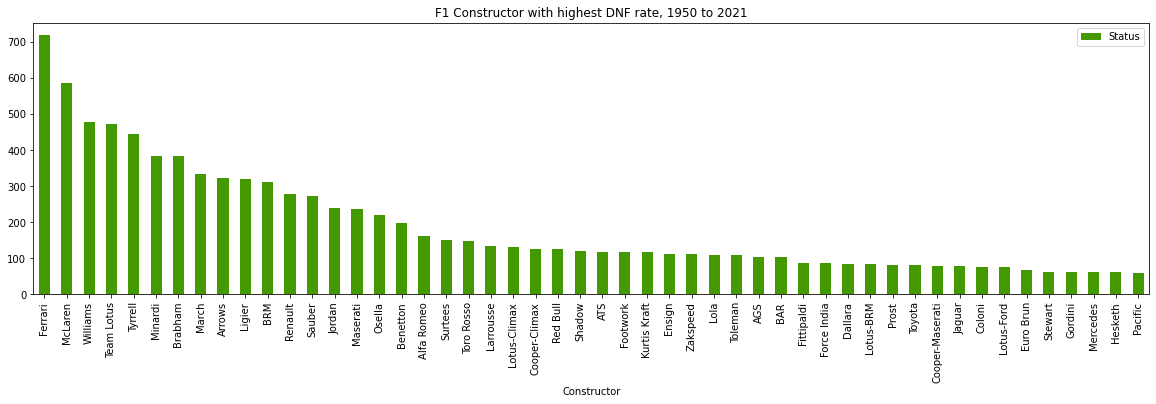

In [31]:
def get_constructor_total_races(df, constructor_name):
    group = df.groupby(by=['Constructor'])['Constructor'].count()
    return group[constructor_name]

df_status_count = results_df[(~results_df['Status'].str.contains('Finished|\+'))]
df_finished = pd.DataFrame(df_status_count.groupby(by=['Constructor'])['Status'].count())
df_finished.sort_values(by=['Status'], ascending=False,inplace=True)
df_finished['Total Races'] = df_finished.apply(lambda x: get_constructor_total_races(results_df, x.name), axis=1)
df_finished['Constructor DNF Rate'] = df_finished.apply(lambda x: round(x['Status']/x['Total Races'],2), axis=1)
df_finished.sort_values(by=['Status','Constructor DNF Rate'],ascending=False,inplace=True)
df_finished.head(50)
df_finished.head(50).plot(kind='bar', y='Status', title="F1 Constructor with highest DNF rate, 1950 to 2021", figsize=(20, 5), color='#449900')

#### Driver age vs winning

Younger drivers win more races? 

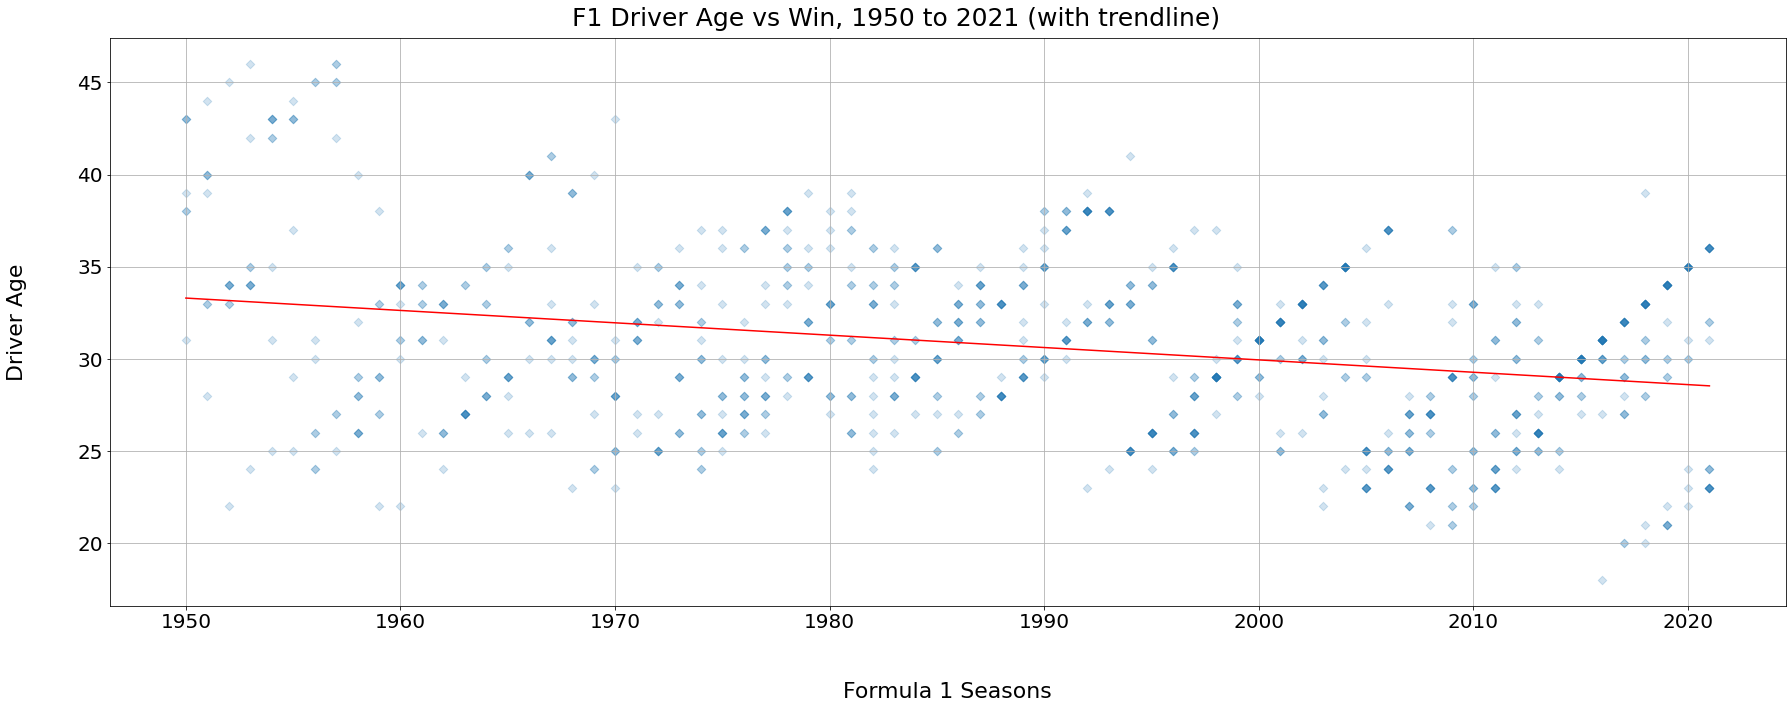

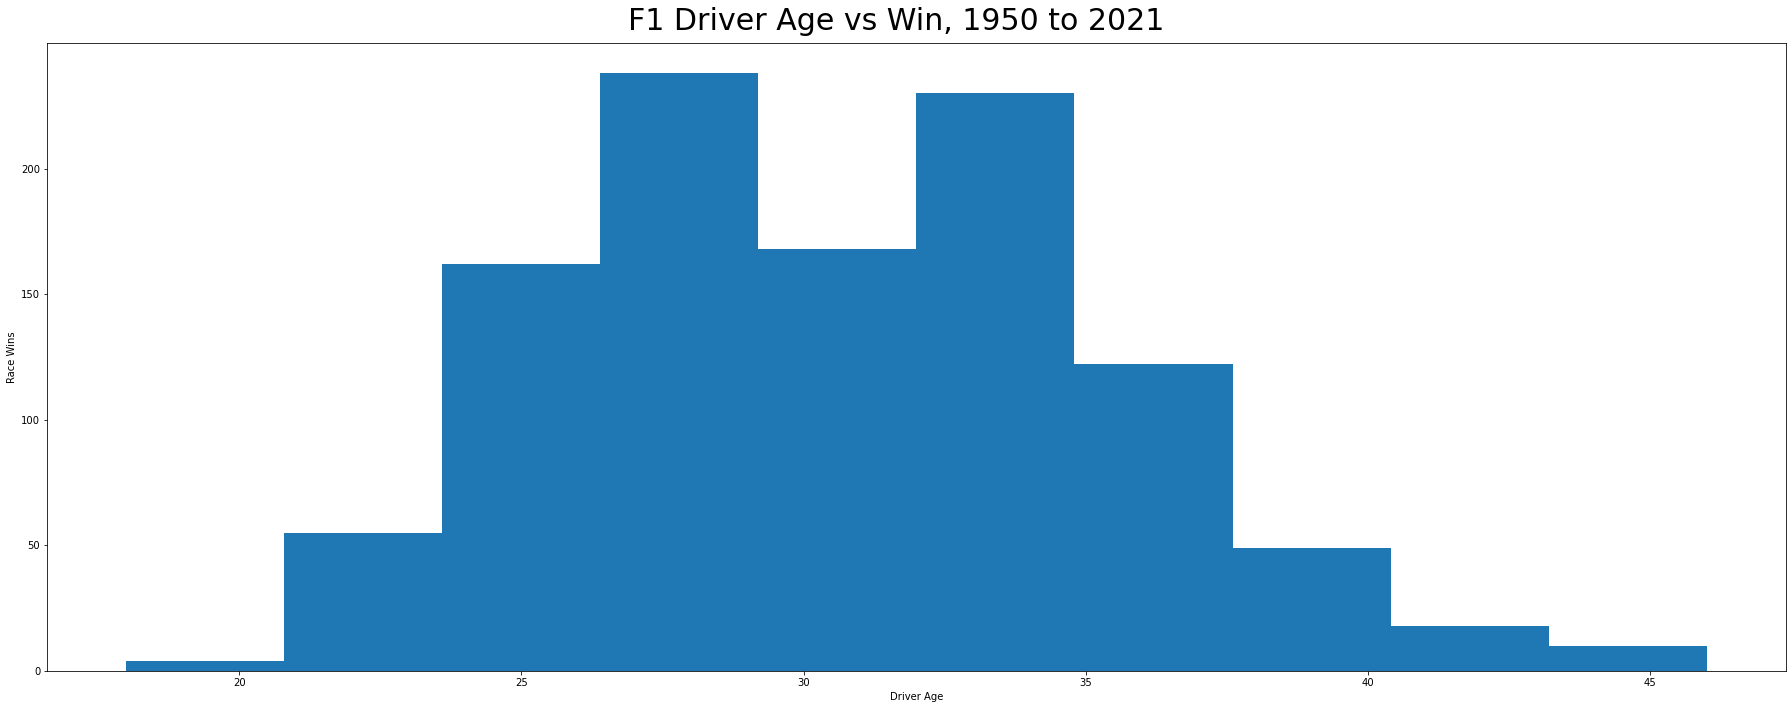

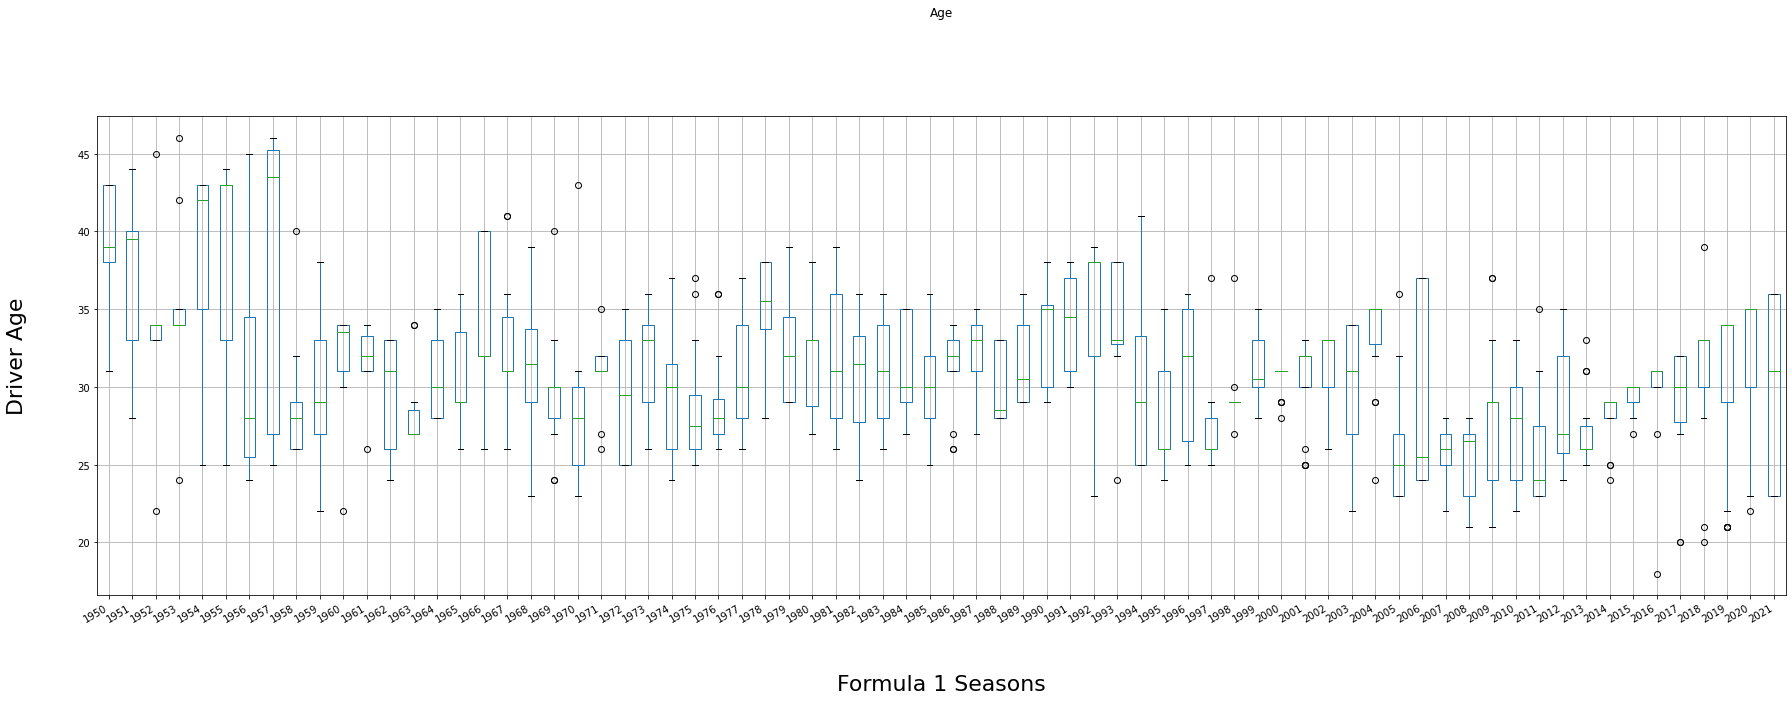

In [32]:
from datetime import date
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def calculate_age(born, race):
    date_born = datetime.strptime(born,'%Y-%m-%d')
    date_race = datetime.strptime(race,'%Y-%m-%d')
    return date_race.year - date_born.year - ((date_race.month, date_race.day) < (date_born.month, date_born.day))

def draw_scatter_trendline(x_values, y_values):
    plt.rcParams["figure.figsize"] = [25, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.titlepad"] = 100 

    fig, ax = plt.subplots()
    ax.scatter(x_values, y_values, marker="D", alpha=0.2) # scatter plot
    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)
    plt.plot(x_values, p(x_values), "r")# trendline
    fig.suptitle('F1 Driver Age vs Win, 1950 to 2021 (with trendline)', fontsize=25)
    plt.xlabel("Formula 1 Seasons", fontsize=22, labelpad=50)
    plt.ylabel("Driver Age", fontsize=22, labelpad=50)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.show()

df_circuits = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first'))  # keep all winners in the new data frame
df_circuits['Age'] = df_circuits.apply(lambda x: int(calculate_age(x['DOB'], x['Race Date'])), axis=1) 

draw_scatter_trendline(df_circuits['Season'].astype(int), df_circuits['Age'])

fig, ax = plt.subplots(1, 1)
plt.hist(df_circuits['Age'], density=False, bins=10)
plt.ylabel('Race Wins')
plt.xlabel('Driver Age')
fig.suptitle('F1 Driver Age vs Win, 1950 to 2021', fontsize=30)

fig2, bx_ax = plt.subplots(1, 1) 
df_circuits.boxplot(column='Age',by='Season',figsize=(20, 8), ax=bx_ax)
bx_ax.xaxis_date()
fig2.autofmt_xdate()
plt.xlabel("Formula 1 Seasons", fontsize=22, labelpad=50)
plt.ylabel("Driver Age", fontsize=22, labelpad=50)
fig2.suptitle('', fontsize=30)
plt.show()

#### Grid position vs winning

Its a well understood fact that the position of of the drivers at the start of the race is a major factor to the results of the race. But by how much? 

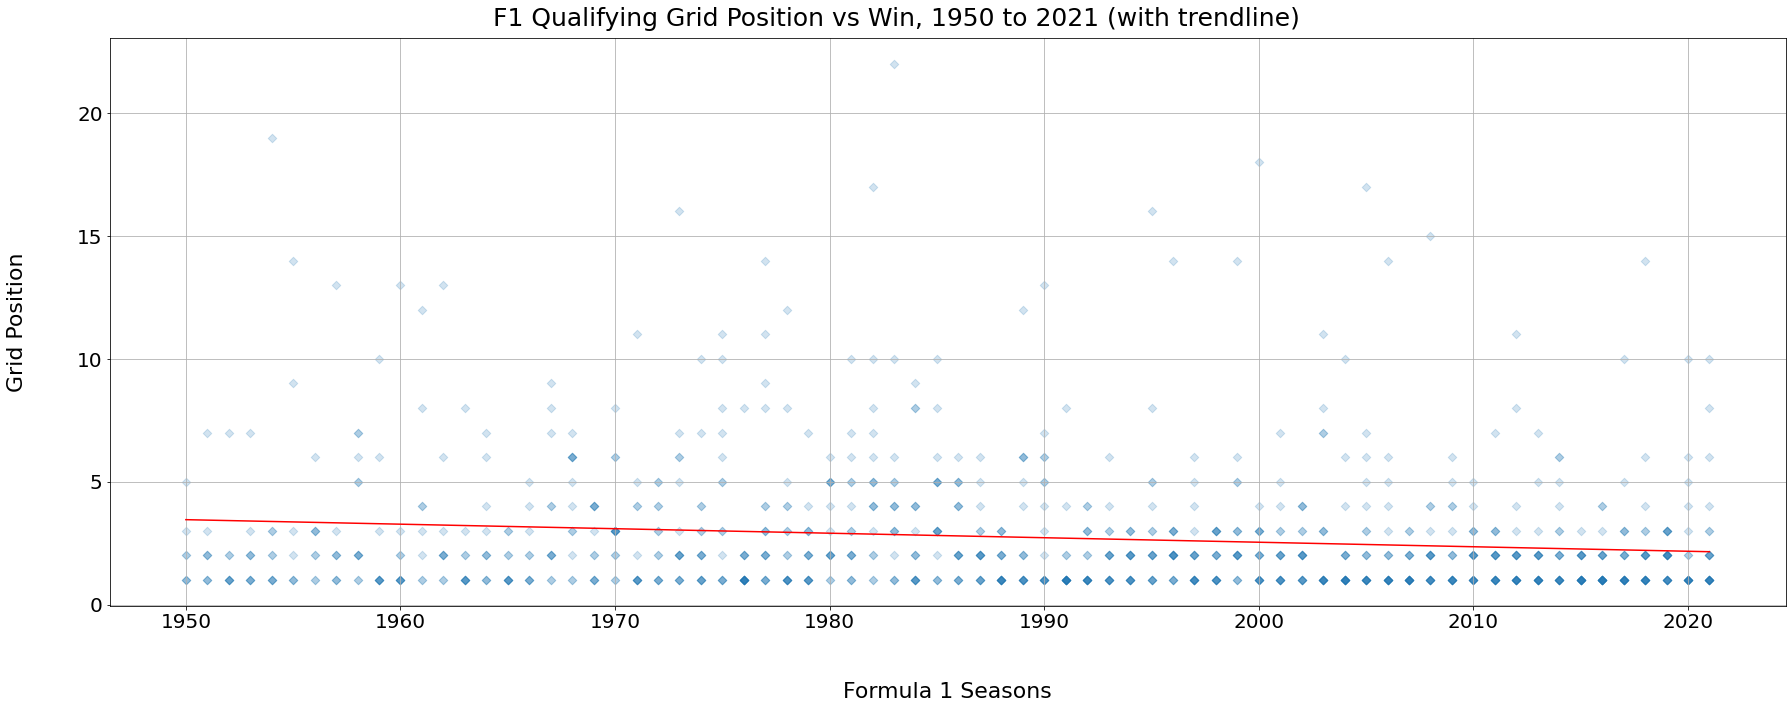

Text(0.5, 0.98, 'F1 Qualifying Grid Position vs Win, 1950 to 2021')

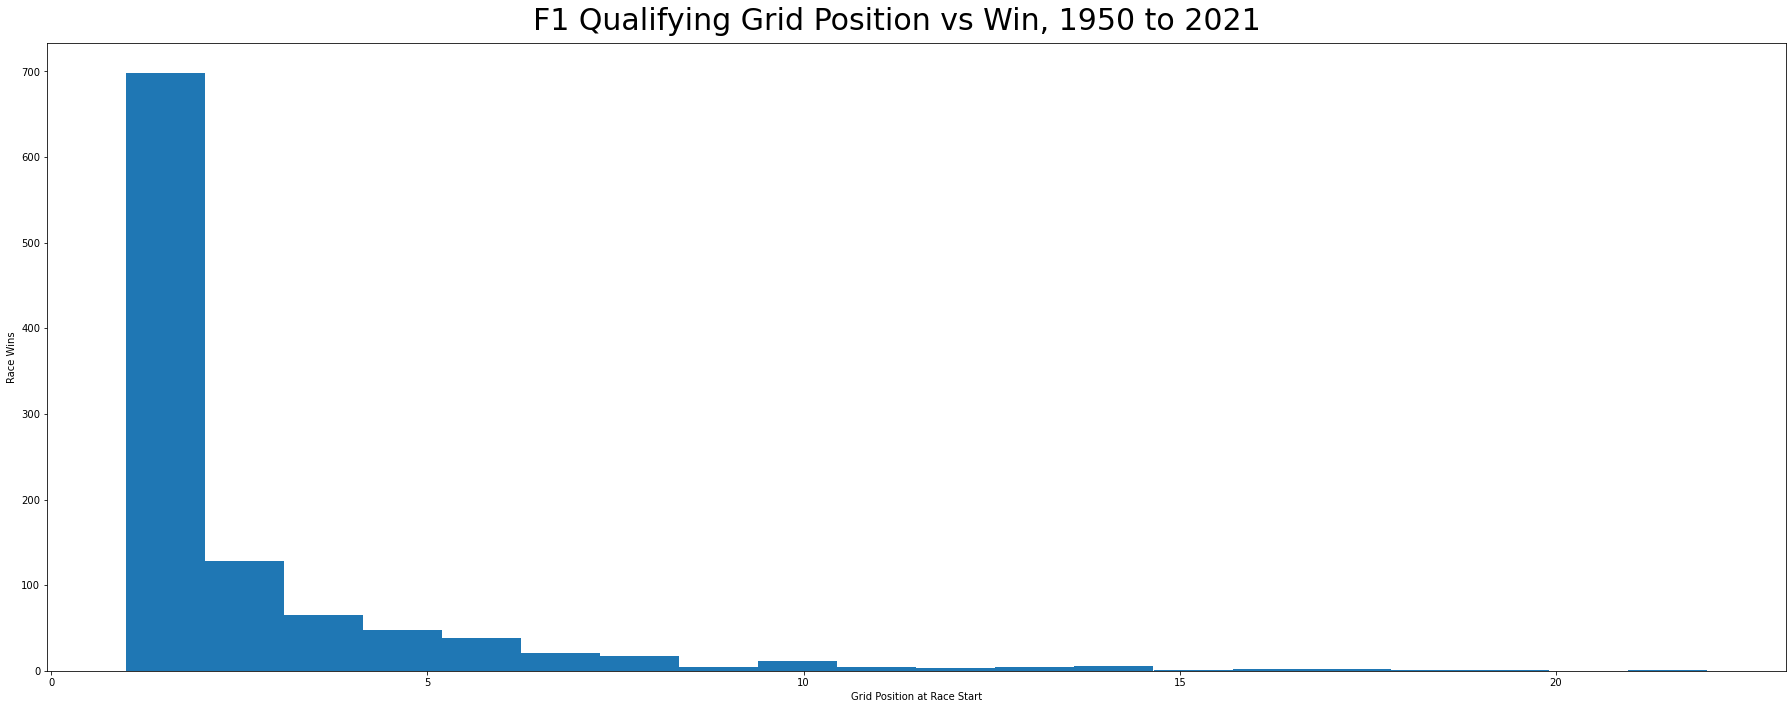

In [33]:
def draw_scatter(x_values, y_values):
    plt.rcParams["figure.figsize"] = [25, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.titlepad"] = 100 

    fig, ax = plt.subplots()
    ax.scatter(x_values, y_values, marker="D", alpha=0.2) # scatter plot
    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)
    plt.plot(x_values, p(x_values), "r")# trendline
    fig.suptitle('F1 Qualifying Grid Position vs Win, 1950 to 2021 (with trendline)', fontsize=25)
    plt.xlabel("Formula 1 Seasons", fontsize=22, labelpad=50)
    plt.ylabel("Grid Position", fontsize=22, labelpad=50)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.show()

df_circuits = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')) # keep all winners in the new data frame
draw_scatter(df_circuits['Season'].astype(int), df_circuits['Grid'])

fig, ax = plt.subplots(1, 1)
plt.hist(df_circuits['Grid'], density=False, bins=20)
plt.ylabel('Race Wins')
plt.xlabel('Grid Position at Race Start')
fig.suptitle('F1 Qualifying Grid Position vs Win, 1950 to 2021', fontsize=30)

#### Home country racing vs winning
In many sports, playing at home gives you a clear advantage over the other team. So it should be similar with car racing, or is it? 

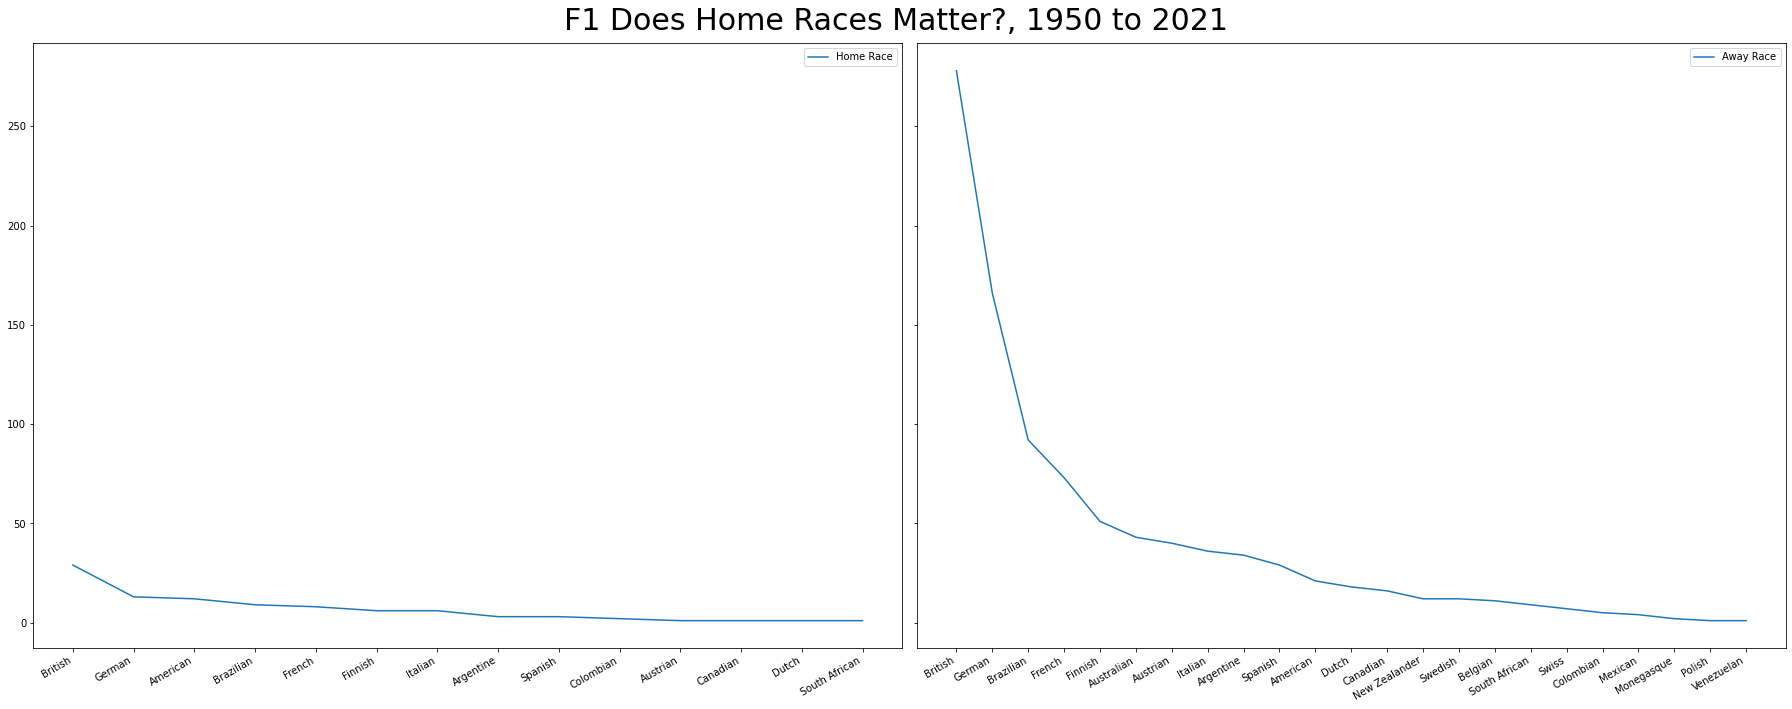

In [34]:
def is_race_in_home_country(driver_nationality, race_country):
    nationality_country_map = {
        'American': ['USA'],
        'American-Italian': ['USA','Italy'],
        'Argentine': ['Argentina'],
        'Argentine-Italian': ['Argentina','Italy'],
        'Australian': ['Australia'],
        'Austrian': ['Austria'],
        'Belgian': ['Belgium'],
        'Brazilian': ['Brazil'],
        'British': ['UK'],
        'Canadian': ['Canada'],
        'Chilean': ['Brazil'],
        'Colombian': ['Brazil'],
        'Czech': ['Austria','Germany'],
        'Danish': ['Germany'],
        'Dutch': ['Netherlands'],
        'East German': ['Germany'],
        'Finnish': ['Germany','Austria'],
        'French': ['France'],
        'German': ['Germany'],
        'Hungarian': ['Hungary'],
        'Indian': ['India'],
        'Indonesian': ['Singapore','Malaysia'],
        'Irish': ['UK'],
        'Italian': ['Italy'],
        'Japanese': ['Japan','Korea'],
        'Liechtensteiner': ['Switzerland','Austria'],
        'Malaysian': ['Malaysia','Singapore'],
        'Mexican': ['Mexico'],
        'Monegasque': ['Monaco'],
        'New Zealander': ['Australia'],
        'Polish': ['Germany'],
        'Portuguese': ['Portugal'],
        'Rhodesian': ['South Africa'],
        'Russian': ['Russia'],
        'South African': ['South Africa'],
        'Spanish': ['Spain','Morocco'],
        'Swedish': ['Sweden'],
        'Swiss': ['Switzerland'],
        'Thai': ['Malaysia'],
        'Uruguayan': ['Argentina'],
        'Venezuelan': ['Brazil']
    }
    
    countries = ['None']
    
    try:
      countries = nationality_country_map[driver_nationality]
    except:
      print("An exception occurred, This driver has no race held in his home country.")
    return race_country in countries

df_winners = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first'))
df_winners['Driver Home Country'] = df_winners.apply(lambda x: is_race_in_home_country(x['Nationality'],x['Country']), axis=1)
df_home = df_winners[(df_winners['Driver Home Country'] == True)]
df_home = pd.DataFrame(df_home.groupby(by=['Nationality'])['Driver Home Country'].count())
df_home.sort_values(by=['Driver Home Country'], ascending=False,inplace=True)
df_home

df_not_home = df_winners[(df_winners['Driver Home Country'] == False)]
df_not_home = pd.DataFrame(df_not_home.groupby(by=['Nationality'])['Driver Home Country'].count())
df_not_home.sort_values(by=['Driver Home Country'], ascending=False,inplace=True)
df_not_home

fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].plot(df_home['Driver Home Country'], label="Home Race")
ax[0].legend()

ax[1].plot(df_not_home['Driver Home Country'], label="Away Race")
ax[1].legend()
plt.setp(ax[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax[1].get_xticklabels(), rotation=30, horizontalalignment='right')
fig.suptitle('F1 Does Home Races Matter?, 1950 to 2021', fontsize=30)

plt.show()


#### Driver recent form vs winning
Time for some feature engineering here. We need a way to describe a driver's recent form and add it as a variable or a new column in the results dataframe. Since the top 10 finishing drivers score points, we can use this to calculate the "Recent Form" variable.

For this we use Panda's [rolling window](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) aggregation, and for nulls we can safely impute to zeros, since that means that they have not accumulated points enough to count against Recent Form. All we have to do now is to do this for all the drivers. 

Key Takeaway here is that the better the driver's recent form, the higher the chance of placing higher in the race.


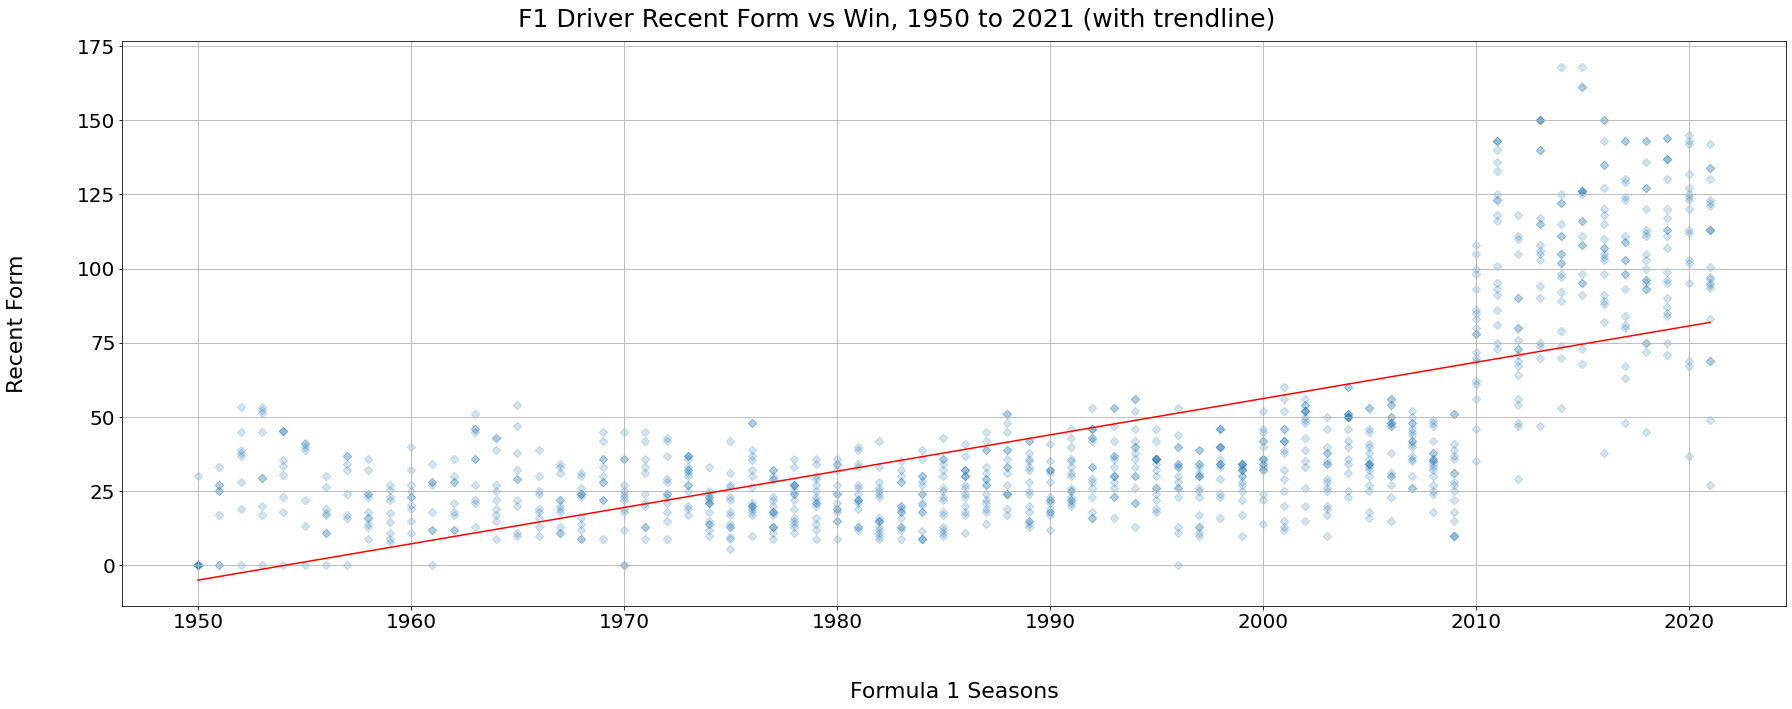

In [36]:
def draw_scatter(x_values, y_values, title):
    plt.rcParams["figure.figsize"] = [25, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.titlepad"] = 100 

    fig, ax = plt.subplots()
    ax.scatter(x_values, y_values, marker="D", alpha=0.2) # scatter plot
    z = np.polyfit(x_values, y_values, 1)
    p = np.poly1d(z)
    plt.plot(x_values, p(x_values), "r")# trendline
    fig.suptitle(title, fontsize=25)
    plt.xlabel("Formula 1 Seasons", fontsize=22, labelpad=50)
    plt.ylabel("Recent Form", fontsize=22, labelpad=50)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    plt.show()

results_df['RollingPoints'] = 0 # add this new rolling points column
# for all drivers, calculate the rolling 6 race points and add to a new column in 
# original data frame, this represents the 'recent form', then for NA's just impute to zero
drivers = results_df['Driver'].unique()
for driver in drivers:
    df_driver = results_df[results_df['Driver']==driver]
    results_df.loc[results_df['Driver']==driver, "RollingPoints"] = df_driver['Points'].rolling(6).sum()
    results_df['RollingPoints'].fillna(value=0,inplace=True)

df_rolling = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')) # keep all winners in the new data frame
draw_scatter(df_rolling['Season'].astype(int), df_rolling['RollingPoints'], 'F1 Driver Recent Form vs Win, 1950 to 2021 (with trendline)')


Text(0, 0.5, 'Recent Form')

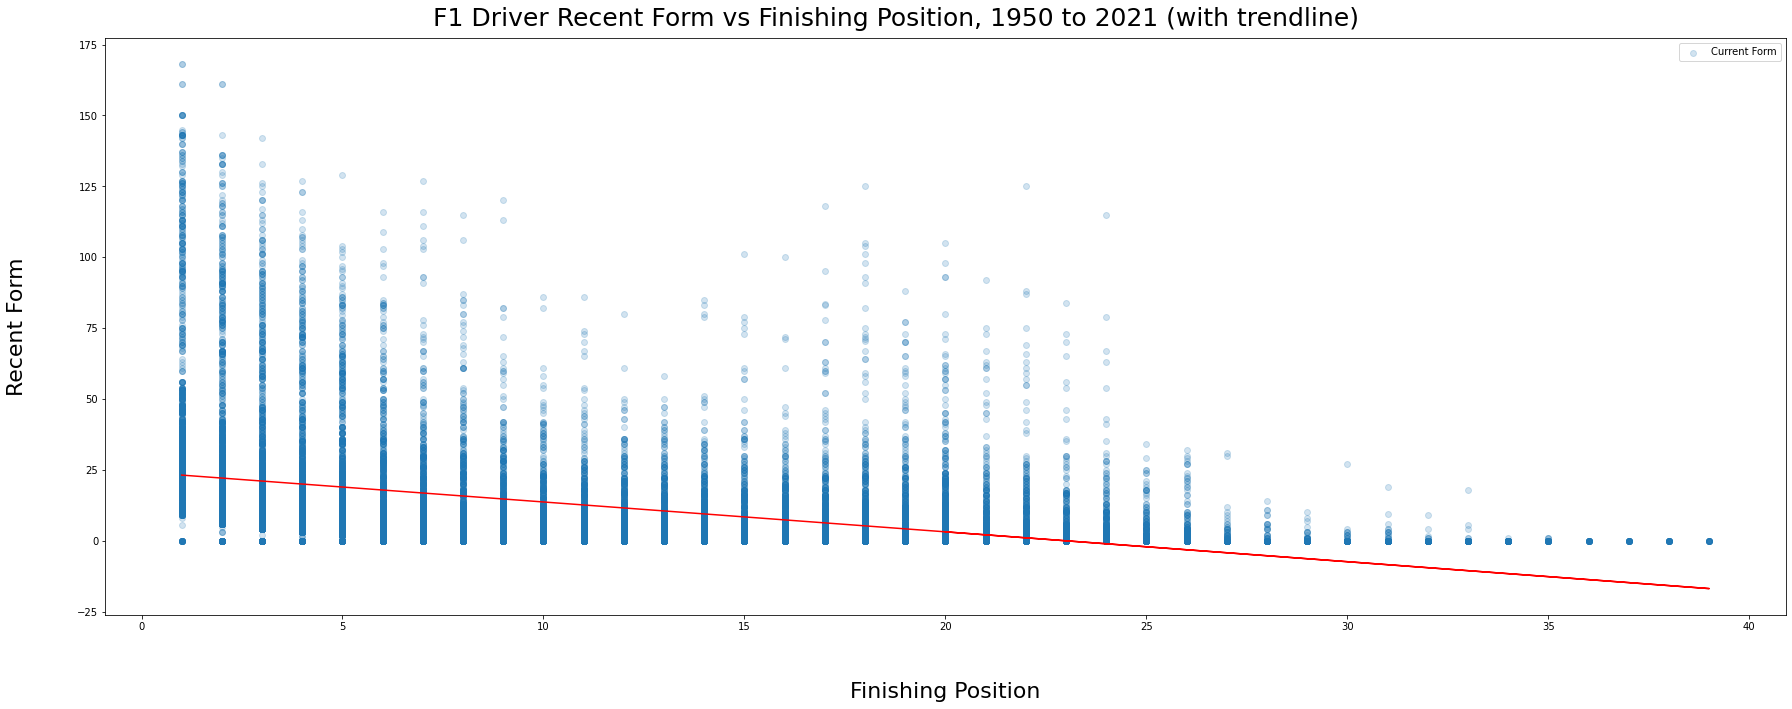

In [37]:
# scatter line graph of recent form for for each race since 1950, then a trendline
fig, ax = plt.subplots(1, 1, sharey=True)
ax.scatter(results_df['Position'], results_df['RollingPoints'], label="Current Form", alpha=0.2) # scatter revent form vs finishing position
ax.legend()

z = np.polyfit(results_df['Position'], results_df['RollingPoints'], 1)
p = np.poly1d(z)
plt.plot(results_df['Position'], p(results_df['Position']), "r")# trendline
fig.suptitle('F1 Driver Recent Form vs Finishing Position, 1950 to 2021 (with trendline)', fontsize=25)
plt.xlabel("Finishing Position", fontsize=22, labelpad=50)
plt.ylabel("Recent Form", fontsize=22, labelpad=50)


#### Constructor Recent Form

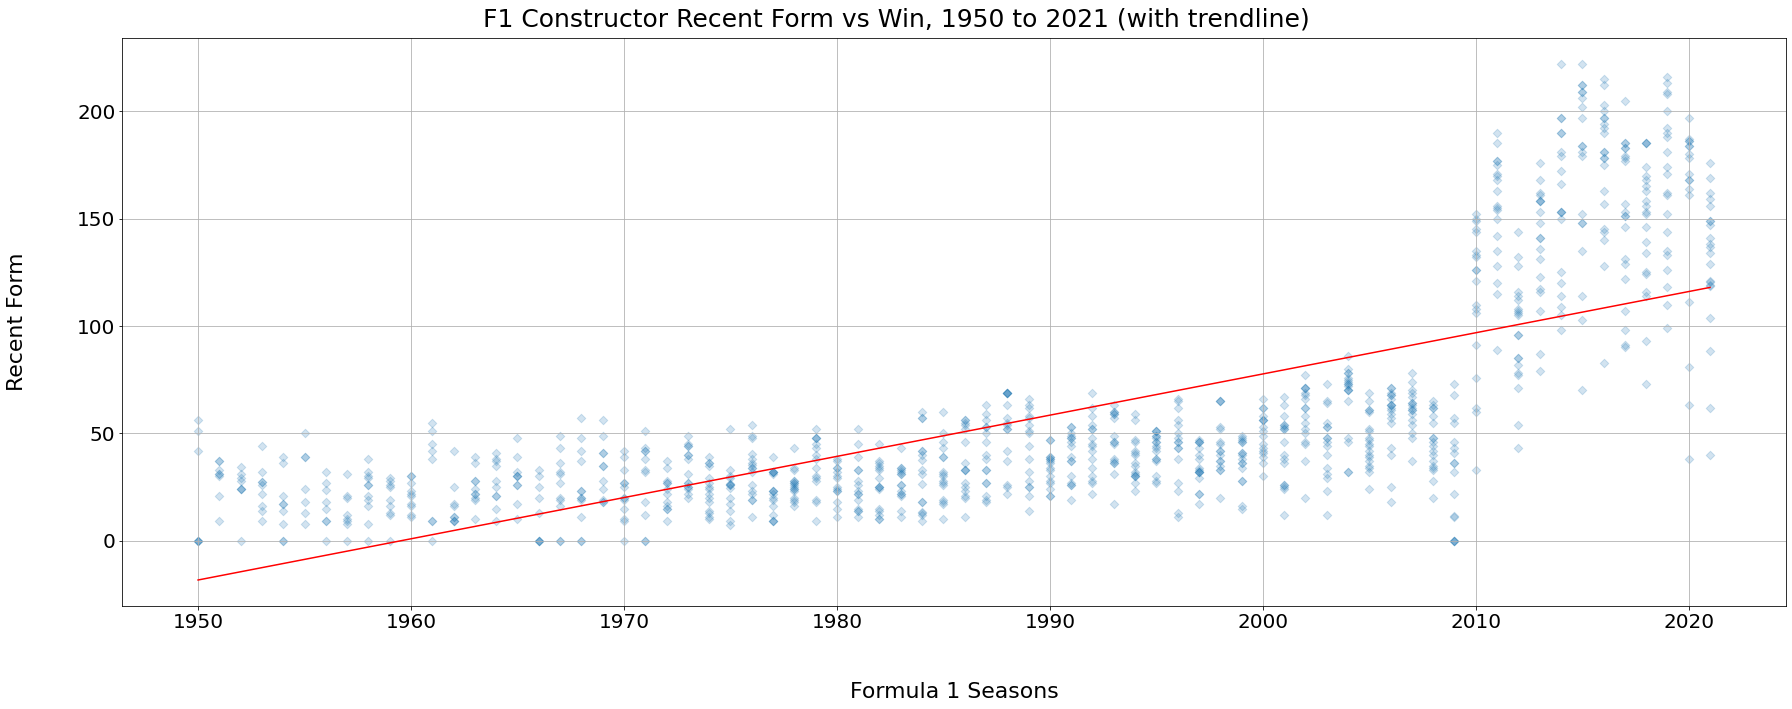

In [39]:
results_df['ConstRollingPoints'] = 0 # add this new rolling points column
# for all Constructors, calculate the rolling 10 race points and add to a new column in 
# original data frame, this represents the 'recent form', then for NA's just impute to zero
constructors = results_df['Constructor'].unique()
for constructor in constructors:
    df_constructor = results_df[results_df['Constructor']==constructor]
    results_df.loc[results_df['Constructor']==constructor, "ConstRollingPoints"] = df_constructor['Points'].rolling(10).sum()
    results_df['ConstRollingPoints'].fillna(value=0,inplace=True)

df_rolling = pd.DataFrame(results_df.drop_duplicates(subset=['Season', 'Round'], keep='first')) # keep all winners in the new data frame
draw_scatter(df_rolling['Season'].astype(int), df_rolling['ConstRollingPoints'],'F1 Constructor Recent Form vs Win, 1950 to 2021 (with trendline)')

Text(0, 0.5, 'Recent Form')

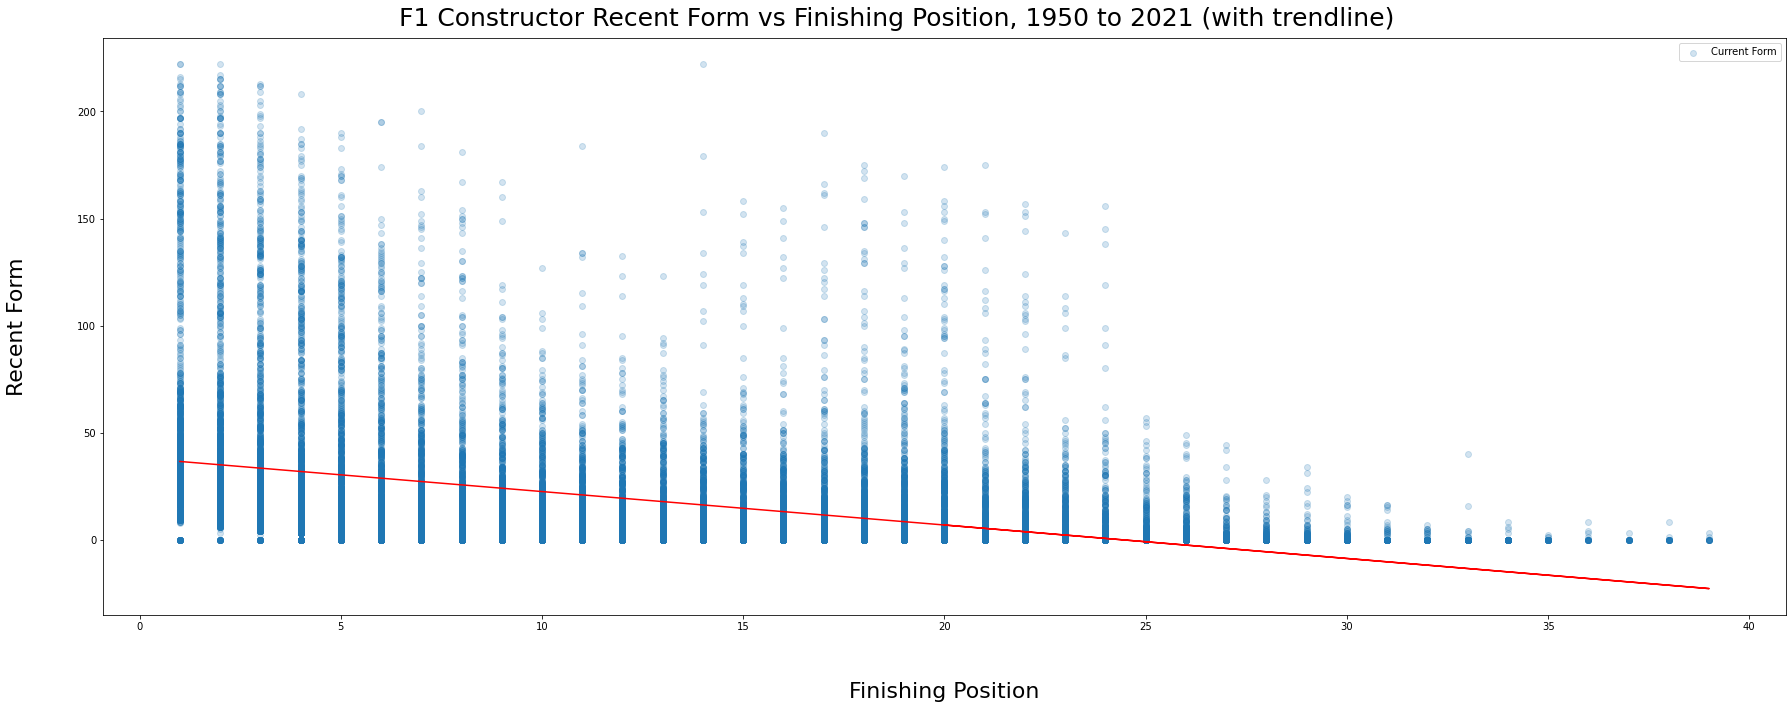

In [40]:
# scatter line graph of recent form for for each race since 1950, then a trendline
fig, ax = plt.subplots(1, 1, sharey=True)
ax.scatter(results_df['Position'], results_df['ConstRollingPoints'], label="Current Form", alpha=0.2) # scatter revent form vs finishing position
ax.legend()

z = np.polyfit(results_df['Position'], results_df['ConstRollingPoints'], 1)
p = np.poly1d(z)
plt.plot(results_df['Position'], p(results_df['Position']), "r")# trendline
fig.suptitle('F1 Constructor Recent Form vs Finishing Position, 1950 to 2021 (with trendline)', fontsize=25)
plt.xlabel("Finishing Position", fontsize=22, labelpad=50)
plt.ylabel("Recent Form", fontsize=22, labelpad=50)

### Shortcomings, Assumptions and Next Steps
- The recent form calculation will need to be refined a bit. Because only the top 10 finishers get points, the other half of the drivers don't get any points for recent form, which is unfair. 
- The weather information is not detailed enough, but that's the only data we can readily get at the moment, so I hope that this data is enough. 
- Driver experience needs to be considered? (ie. Rookies tend to have poor showing at the start of their career, and more experienced drivers tend to do better)
- Maybe we need to engineer another feature called Points per Race, showing a drivers propensity for a points finish, much like a baseball player's [Batting Average](https://en.wikipedia.org/wiki/Batting_average_(baseball)) 

As a next step, we will now start investigating what Machine Learning algorithm to use, and if its best to treat it as a Classification, or a Regression problem. 